In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD
import cv2

In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)

images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
                        transform=transforms.ToTensor())


loading annotations into memory...
Done (t=9.22s)
creating index...
index created!


In [61]:
from faster_rcnn.faster_rcnn import  RPN

In [62]:
net = RPN()
net.cuda()
net.train()

RPN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [63]:
param = list(net.parameters())[-6:]

In [64]:
optimizer = SGD(param, 0.001,
                        momentum=True,
                        weight_decay=0.001)

In [65]:
def train(train_loader, optimizer, model, epoch):
    model.train()
    
    for i, input in enumerate(train_loader):
        if i > epoch:
            break
        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = blobs['gt_boxes']
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        output = model(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)
        loss = model.loss
        print loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        log_text = 'step %d, image: %s' % (
            i, blobs['im_name'])
        print log_text 

In [ ]:
train(cap, optimizer=optimizer, model=net, epoch=10000)

In [67]:
blobs = cap[19856]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = blobs['gt_boxes']
gt_ishard = blobs['gt_ishard']
dontcare_areas = blobs['dontcare_areas']

In [68]:
_, result = net(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)

im_size: (600.0, 800.0)
scale: 1.25
score map size: (1, 9, 18, 25)


In [82]:
data =  result.data.cpu().numpy()
print data[:, 0]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

[   4.14   22.24  599.    450.55   16.  ]
[  56.09  258.88  521.07  477.92   40.  ]


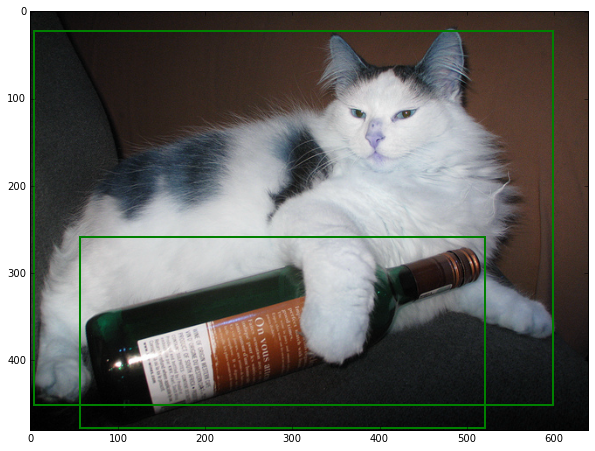

In [77]:
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
im_info = blobs['im_info'][0]
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)

# Create a Rectangle patch
for i, box in enumerate(blobs['gt_boxes']):
    print box
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=2,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()


(650, 5)


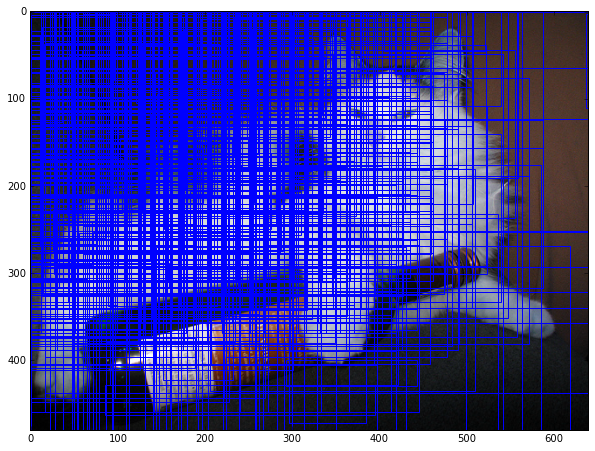

In [79]:
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
im_info = blobs['im_info'][0]
# Display the image
im_data = cv2.imread(img_path)

ax.imshow(im_data)
print data.shape
# Create a Rectangle patch
for i, box_data in enumerate(data):
    box = box_data[1:]
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1] ,linewidth=1,edgecolor='b',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()